In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Hack pro GPU na Windows
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

### Načteme data

In [3]:
import numpy as np
import os

PATH = os.path.join("datasets", "09", "jena")

In [4]:
import pandas as pd

def load_data(file, path=PATH):
    csv = os.path.join(path, file)
    return pd.read_csv(csv)

In [24]:
data = load_data("jena_climate_2009_2016.csv")
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
train_index = 200000 # 0 - 200000 trénovací
valid_index = 300000 # 200001 - 300000 validační
                     # zbytek testovací

**Nyní potřebujeme nachystat trénovací data**

Trénovací data chceme mít např. v této podobě: 
- features: údaje za X dní zpátky od zvoleného bodu
- label: údaj za 24 hodin do budoucna od zvoleného bodu

Protože by bylo velmi neúsporné chystat takto postupně všechny posloupnosti dat, nachystáme si na to generátor, který bude trénovací data vytvářet za běhu.  

* `data`
* `lookback`: kolik časových kroků zpátky chceme jít
* `future`: kolik časových kroků do budoucna má být label
* `min_index`, `max_index`: v jaké oblasti dat se chceme pohybovat (důležité, abychom nedostali testovací data do trénovacích)
* `shuffle`: jestli se mají data vybírat náhodně z definované oblasti
* `batch_size`
* `step`: po kolika krocích vybírat data. 6 = 6x10 minut = hodina

In [25]:
lookback = 1440 # 10 dní zpátky 
step = 6  # po kolika krocích vybírat časové body
future = 6 # 6 x 24 = 24 hodin dopředu
batch_size = 128 
timesteps_in_instance = int(lookback / step)

In [10]:
def generator(data, lookback, future, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - future - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + future][1]
        yield samples, targets

### Můžeme ještě vyzkoušet pracovat s periodicitou

V případě časové řady s počasím se nabízí roční a denní periodicita

In [26]:
import time
import datetime

timestamps = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S').map(datetime.datetime.timestamp)

In [27]:
day = 24*60*60
year = (364.2425)*day

data['Day sin'] = np.sin(timestamps * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamps * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamps * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamps * (2 * np.pi / year))

In [28]:
data.drop(columns=['Date Time'], inplace=True)

In [29]:
np_data = data.to_numpy()

In [30]:
train_steps = (train_index - lookback) // batch_size
valid_steps = (valid_index - train_index - lookback -1) // batch_size
test_steps = (len(np_data) - valid_index - lookback -1) // batch_size

In [31]:
# scaling
mean = np_data[:train_index].mean(axis=0)
np_data -= mean
std = np_data[:train_index].std(axis=0)
np_data /= std

In [32]:
train_gen = generator(np_data,
                      lookback=lookback,
                      future=future,
                      min_index=0,
                      max_index=train_index,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

valid_gen = generator(np_data,
                    lookback=lookback,
                    future=future,
                    min_index=train_index+1,
                    max_index=valid_index,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(np_data,
                     lookback=lookback,
                     future=future,
                     min_index=valid_index+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [33]:
(X, y) = next(train_gen)

In [34]:
X.shape

(128, 240, 18)

In [35]:
model = keras.models.Sequential([
    layers.GRU(32, return_sequences=True, input_shape=(timesteps_in_instance, np_data.shape[1])),
    layers.GRU(32),
    layers.Dense(24),
])

In [36]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae')

In [37]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='09_timeseries_gru_multi_period.keras', save_best_only=True, monitor='val_loss')

In [38]:
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=15,
                    validation_data=valid_gen,
                    validation_steps=valid_steps,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/15
  37/1551 [..............................] - ETA: 6:56 - loss: 0.7338

KeyboardInterrupt: 

<AxesSubplot:>

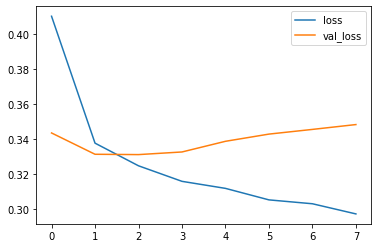

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [ ]:
np.min(history.history['val_loss'])

0.3313027322292328

In [ ]:
model = keras.models.load_model('09_timeseries_gru_multi_period.keras')

In [ ]:
model.evaluate(test_gen, steps=test_steps)

930/930 [==============================] - 8s 6ms/step - loss: 0.3417


0.3417198956012726